# Hello World!
## Battle of the Neighborhoods - Part I -

Welcome to my Battle of Neighborhoods project, For the first part of this project I will tell you about the Business Problem and the data that I will be using to solve the problem.

## Introduction

The potential of the coffee industry in Indonesia is quite large. Because, as a tropical country, Indonesia is a suitable location for coffee cultivation. Therefore, the cultivation and management of Indonesian specialty coffee is a strategic step that must continue to be developed. The culture of drinking coffee has indeed spread to various countries not only in Indonesia. There is a very high demand for coffee which makes the coffee business opportunity more profitable. The coffee business has become one of the businesses that has been taken into account where the beverage product is in high demand.

Jakarta is one of the cities in Indonesia which has a lot of coffee shops. From 2013 until the end of 2018, there have been several coffee shops spreads around every corner of the capital city of Jakarta, even from several locations of offices, schools, or campuses. this report will be targeted to a client interested in opening a Coffee shop in Jakarta, Indonesia.

## Business Problem

One of the client is interested to open a specialty coffee shop in Jakarta. Unfortunately, he has issue on making a decision about the location to open the coffee shop. Though, the client is quite optimist of his homegrown specialty coffee. His first issue is that he wanted to know which place has lesser competition so that he can grow his business in a stable pace without fighting over customer, whether it is battle between coffee shops or other kind of cafes or restaurant. The second concern is that he wanted the place to not very far away from his supplier in the central Jakarta to minimize the time in retrieving the supply from the supplier. Finally, last but not least, he wanted the place to have an adequate population. So, where will I recommend the best place for him to open the coffee shop?

## The choice of data that I will use

In order to solve the problem, I need a precise data that can tell the population of each district. Furthermore, the data should also can tell the nighborhood within each district since that data will be used on the last section to see the distance on each neighborhood from the central Jakarta (supplier's place) and the population within the neighborhood. So, I will use the following data:  
1. Dataset from [Jakarta Open Data](http://data.jakarta.go.id/dataset/data-jumlah-penduduk-provinsi-dki-jakarta-berdasarkan-kelompok-usia-per-kelurahan). I choose to use this data since it is the most up to date within the site.  
This data consists of:  
  * The name of districts and neighborhoods
  * The spread of population based on gender (Male and Female)
  * The spread of population based on age (from 0 to above 75 years old with 4 years step)
  * The cities, districts and neighborhood of those population’s spread  
  

2. Latitude and Longitude from geopy.geocoders package that will be cast on each data  
3. Venues list that I can get from real-time foursquare API

## Method in solving this problem

In this project I will utilize unsupervised machine learning algorithm which is clustering. But, before I go to that part, the first thing I need to do is to pre-process the data
1. On the Dataset from Jakarta Open Data, I will sort the data and group it by district, before I sum the population to get a new column, I will drop the population whose age is in the range 0-4 since those population is rather out from the target market (in case growth hacking is needed), another opinion as why I don't drop the age >75 is because from my personal experience some of those people are indeed still drink coffee in Indonesia. At this point, I will have a sorted data about Jakarta grouped by district.  
2. After that I will contruct a function to get the latitude and longitude from each district (please note i will not use the post code to get the list of the latitude and longitude, but I will cast the district instead.)
3. Next, I will get the list of venues from foursquare API and then cluster it with unsupervised machine learning clustering algorithm (in this case, I will use K-means) to see the place with less competition whether it is another coffee shops or cafes.
4. After I got the cluster from each label with the best K, I will pick the clusters that look promising (have less competition as the first concern from the client)
5. Next, I will sort the data from the picked clusters to see the distance from the supplier to pick the best district.
6. Finally, after I got the result I will plot the neighborhood population within the best district so the client can see the comparison between each places before he makes the final decision.

# Battle of the Neighborhoods - Part II -
This is the part II of the project, this is intended for the last week assignment. But if you are still in the 4th week, I suggest you to take a glimpse on the overall results of the notebook so you will understand the process.

### First, let me import some useful libraries for this project

In [1]:
import numpy as np 

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

from geopy.geocoders import Nominatim

import requests 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium 

print('Libraries imported.')

Libraries imported.


**After that, I read the csv into dataframe from the link of Jakarta Open Data**  
please note, I will not use markdowns on all description. I will write it in comment code (#) for some of them  
The column name in this dataset is still in Indonesian, but I will rename it later on

In [114]:
df = pd.read_csv("http://data.jakarta.go.id/dataset/db70385d-f9bb-4b49-90f8-04ce155d23f3/resource/a292f2cb-04df-4415-94e7-517e85bc3ab0/download/Data-Jumlah-Penduduk-Berdasarkan-Kelompok-Usia-Per-Kelurahan-Tahun-2018.csv")

In [115]:
#this is the size of the data from Jakarta Open Data
df.shape

(8544, 7)

In [116]:
#five first rows of the dataset
df.head()

,tahun,kabupaten,kecamatan,kelurahan,jenis_kelamin,usia,jumlah
0,2018,ADM. KEPULAUAN SERIBU,KEPULAUAN SERIBU UTARA,PULAU PANGGANG,Laki-Laki,0-4,332
1,2018,ADM. KEPULAUAN SERIBU,KEPULAUAN SERIBU UTARA,PULAU KELAPA,Laki-Laki,0-4,328
2,2018,ADM. KEPULAUAN SERIBU,KEPULAUAN SERIBU UTARA,PULAU HARAPAN,Laki-Laki,0-4,104
3,2018,ADM. KEPULAUAN SERIBU,KEPULAUAN SERIBU SELATAN,PULAU UNTUNG JAWA,Laki-Laki,0-4,117
4,2018,ADM. KEPULAUAN SERIBU,KEPULAUAN SERIBU SELATAN,PULAU TIDUNG,Laki-Laki,0-4,289


In [117]:
#Let's drop the region, year and gender column first
df.drop(df[['kabupaten','tahun','jenis_kelamin']], axis = 1, inplace = True)
df.head()

,kecamatan,kelurahan,usia,jumlah
0,KEPULAUAN SERIBU UTARA,PULAU PANGGANG,0-4,332
1,KEPULAUAN SERIBU UTARA,PULAU KELAPA,0-4,328
2,KEPULAUAN SERIBU UTARA,PULAU HARAPAN,0-4,104
3,KEPULAUAN SERIBU SELATAN,PULAU UNTUNG JAWA,0-4,117
4,KEPULAUAN SERIBU SELATAN,PULAU TIDUNG,0-4,289


In [118]:
#Let's drop the data for the people around 0-4 years old
df.drop(df.index[df['usia'] == '0-4'], inplace = True)
df.head()

,kecamatan,kelurahan,usia,jumlah
267,KEPULAUAN SERIBU UTARA,PULAU PANGGANG,5-9,313
268,KEPULAUAN SERIBU UTARA,PULAU KELAPA,5-9,353
269,KEPULAUAN SERIBU UTARA,PULAU HARAPAN,5-9,114
270,KEPULAUAN SERIBU SELATAN,PULAU UNTUNG JAWA,5-9,141
271,KEPULAUAN SERIBU SELATAN,PULAU TIDUNG,5-9,284


### The next step is to group the data by district. I will merge the neighborhood by applying join and merge population by summing it up

In [119]:
df.drop(df[['usia']],axis = 1, inplace = True)
df.rename(columns = {'kecamatan':'District','kelurahan':'Neighborhood','jumlah':'Total population'}, inplace = True)
sorted_1 = df.groupby(['District'])['Neighborhood'].apply(','.join).reset_index()
sorted_2 = df.groupby(['District'])['Total population'].sum().reset_index()
df_merged = sorted_1.join(sorted_2.set_index('District'), on='District')
df_merged = df_merged.reset_index(drop=True)
df_merged.head()

,District,Neighborhood,Total population
0,CAKUNG,"JATINEGARA,RAWA TERATE,PENGGILINGAN,CAKUNG TIM...",461622
1,CEMPAKA PUTIH,"CEMPAKA PUTIH TIMUR,CEMPAKA PUTIH BARAT,RAWASA...",89799
2,CENGKARENG,"CENGKARENG BARAT,DURI KOSAMBI,RAWA BUAYA,KEDAU...",457629
3,CILANDAK,"CILANDAK BARAT,LEBAK BULUS,PONDOK LABU,GANDARI...",189780
4,CILINCING,"CILINCING,SUKAPURA,MARUNDA,KALIBARU,SEMPER TIM...",349075


### In this code below, it is shown that there are dulplicates in the neighborhood data. It is because the data from the website group it by age and gender, so there will be duplicates for the neighborhood part. This will obstruct my analysis later on, so I have to remove the duplicates first

In [120]:
df_merged.iloc[1,1]

'CEMPAKA PUTIH TIMUR,CEMPAKA PUTIH BARAT,RAWASARI,CEMPAKA PUTIH TIMUR,CEMPAKA PUTIH BARAT,RAWASARI,CEMPAKA PUTIH TIMUR,CEMPAKA PUTIH BARAT,RAWASARI,CEMPAKA PUTIH TIMUR,CEMPAKA PUTIH BARAT,RAWASARI,CEMPAKA PUTIH TIMUR,CEMPAKA PUTIH BARAT,RAWASARI,CEMPAKA PUTIH TIMUR,CEMPAKA PUTIH BARAT,RAWASARI,CEMPAKA PUTIH TIMUR,CEMPAKA PUTIH BARAT,RAWASARI,CEMPAKA PUTIH TIMUR,CEMPAKA PUTIH BARAT,RAWASARI,CEMPAKA PUTIH TIMUR,CEMPAKA PUTIH BARAT,RAWASARI,CEMPAKA PUTIH TIMUR,CEMPAKA PUTIH BARAT,RAWASARI,CEMPAKA PUTIH TIMUR,CEMPAKA PUTIH BARAT,RAWASARI,CEMPAKA PUTIH TIMUR,CEMPAKA PUTIH BARAT,RAWASARI,CEMPAKA PUTIH TIMUR,CEMPAKA PUTIH BARAT,RAWASARI,CEMPAKA PUTIH TIMUR,CEMPAKA PUTIH BARAT,RAWASARI,CEMPAKA PUTIH TIMUR,CEMPAKA PUTIH BARAT,RAWASARI,CEMPAKA PUTIH TIMUR,CEMPAKA PUTIH BARAT,RAWASARI,CEMPAKA PUTIH TIMUR,CEMPAKA PUTIH BARAT,RAWASARI,CEMPAKA PUTIH TIMUR,CEMPAKA PUTIH BARAT,RAWASARI,CEMPAKA PUTIH TIMUR,CEMPAKA PUTIH BARAT,RAWASARI,CEMPAKA PUTIH TIMUR,CEMPAKA PUTIH BARAT,RAWASARI,CEMPAKA PUTIH TIMUR

### By applying the code below I can remove the duplicates in the neighborhood column

In [121]:
df_merged['Neighborhood'] = df_merged['Neighborhood'].apply(lambda x: ','.join(sorted(set(x.split(',')))))

In [122]:
#Let's check the result
df_merged.iloc[1,1]

'CEMPAKA PUTIH BARAT,CEMPAKA PUTIH TIMUR,RAWASARI'

In [126]:
#Check the pre-processed data shape again
df_merged.shape

(44, 3)

In [128]:
#check the first 10 rows of the data
df_merged.head(10)

,District,Neighborhood,Total population
0,CAKUNG,"CAKUNG BARAT,CAKUNG TIMUR,JATINEGARA,PENGGILIN...",461622
1,CEMPAKA PUTIH,"CEMPAKA PUTIH BARAT,CEMPAKA PUTIH TIMUR,RAWASARI",89799
2,CENGKARENG,"CENGKARENG BARAT,CENGKARENG TIMUR,DURI KOSAMBI...",457629
3,CILANDAK,"CILANDAK BARAT,CIPETE SELATAN,GANDARIA SELATAN...",189780
4,CILINCING,"CILINCING,KALIBARU,MARUNDA,ROROTAN,SEMPER BARA...",349075
5,CIPAYUNG,"BAMBU APUS,CEGER,CILANGKAP,CIPAYUNG,LUBANG BUA...",237204
6,CIRACAS,"CIBUBUR,CIRACAS,KELAPA DUA WETAN,RAMBUTAN,SUSUKAN",263342
7,DUREN SAWIT,"DUREN SAWIT,KLENDER,MALAKA JAYA,MALAKA SARI,PO...",372835
8,GAMBIR,"CIDENG,DURI PULO,GAMBIR,KEBON KELAPA,PETOJO SE...",94310
9,GROGOL PETAMBURAN,"GROGOL,JELAMBAR,JELAMBAR BARU,TANJUNG DUREN SE...",205166


In [129]:
#Let's save it just in case something went wrong
df_merged.to_csv('sorted jakarta data.csv')

# Time to get Latitude and Longitude

In [133]:
#cast the district first since I will use for looping to get the latitude and longitude
list_district = df_merged['District'].values.tolist()
#check the first 10 district on the list
print(list_district[0:10])

['CAKUNG', 'CEMPAKA PUTIH', 'CENGKARENG', 'CILANDAK', 'CILINCING', 'CIPAYUNG', 'CIRACAS', 'DUREN SAWIT', 'GAMBIR', 'GROGOL PETAMBURAN']


### The for looping below use geocoder package so I can cast geocoder.arcgis function to retrieve all the location's latitude and longitude in a single for looping and then append it to the list

In [134]:
import geocoder

latitude_list = []
longitude_list = []

for n in list_district:
    g = geocoder.arcgis(f'{n}, Jakarta, Indonesia').latlng
    print(g)
    latitude_list.append(g[0])
    longitude_list.append(g[1])

[-6.196229999999957, 106.93522000000007]
[-6.175999999999931, 106.87060000000008]
[-6.1305999999999585, 106.74559000000005]
[-6.2905099999999265, 106.79491000000007]
[-6.113579999999956, 106.94911000000008]
[-6.326729999999941, 106.90298000000007]
[-6.3287899999999695, 106.88475000000005]
[-6.2350099999999316, 106.92261000000008]
[-6.17298999999997, 106.81571000000008]
[-6.167769999999962, 106.78460000000007]
[-6.343079999999929, 106.81745000000006]
[-6.232649999999978, 106.88539000000009]
[-6.185889999999972, 106.85593000000006]
[-6.122099999999932, 106.70727000000005]
[-6.251469999999927, 106.79754000000008]
[-6.263859999999966, 106.77519000000007]
[-6.197019999999952, 106.77308000000005]
[-6.16020999999995, 106.90478000000007]
[-6.165839999999946, 106.85396000000009]
[-6.218229999999949, 106.73749000000004]
[-5.797329999999931, 106.49630000000008]
[-5.74536999999998, 106.61380000000008]
[-6.127159999999947, 106.89919000000003]
[-6.283439999999928, 106.87158000000005]
[-6.28504999999

In [137]:
#Let's check the length of the list first to see whether geocoder successfully return all the location's latitude and longitude
print(len(latitude_list))
print(len(longitude_list))

44
44


### Add the new list to the dataframe

In [138]:
df_merged['Latitude'] = latitude_list
df_merged['Longitude'] = longitude_list

In [139]:
#Let's check it to confirm the results
df_merged.head()

,District,Neighborhood,Total population,Latitude,Longitude
0,CAKUNG,"CAKUNG BARAT,CAKUNG TIMUR,JATINEGARA,PENGGILIN...",461622,-6.19623,106.93522
1,CEMPAKA PUTIH,"CEMPAKA PUTIH BARAT,CEMPAKA PUTIH TIMUR,RAWASARI",89799,-6.17600,106.87060
2,CENGKARENG,"CENGKARENG BARAT,CENGKARENG TIMUR,DURI KOSAMBI...",457629,-6.13060,106.74559
3,CILANDAK,"CILANDAK BARAT,CIPETE SELATAN,GANDARIA SELATAN...",189780,-6.29051,106.79491
4,CILINCING,"CILINCING,KALIBARU,MARUNDA,ROROTAN,SEMPER BARA...",349075,-6.11358,106.94911


### After that, in order to complete the dataframe I need to know the appox. distance between each district to the supplier's location
The supplier is called Biji Kopi Records. It is located in Central Jakarta and the location's latitude and longitude is in the code below

In [142]:
supplier_latitude = -6.171009
supplier_longitude = 106.852772

### In order to know the approx. distance, I will use haversine formula
For those who don't know what haversine formula is, it is basically a formula that determines the great-circle distance between two points on a sphere given their longitudes and latitudes. In my opinion however, if you check it on the gmaps and see the actual distance, it will return different result. That is because haversine didn't count the factor of traffic, road and so on. So the actual result from the haversine may be in the form of displacement rather than actual travel distance.

In [147]:
#this is the function that will return the result of haversine

from math import radians, cos, sin, asin, sqrt
def haversine(lat, lng, supplier_latitude, supplier_longitude):
    
    lat, lng, supplier_latitude, supplier_longitude = map(radians, [lat, lng, supplier_latitude, supplier_longitude])
    
    dlon = supplier_longitude - lng
    dlat = supplier_latitude - lat 
    a = sin(dlat/2)**2 + cos(lat) * cos(supplier_latitude) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    
    return c * r

In [148]:
#let's check whether the function works properly by using CAKUNG latitude and longitude
haversine(-6.19623, 106.93522, -6.171009, 106.852772)

9.536156964425127

### I will use for looping to get the distance list

In [153]:
distance_list = []

for x,y in zip(latitude_list, longitude_list):
    d = haversine(x, y, supplier_latitude, supplier_longitude)
    distance_list.append(d)

In [154]:
#check whether the length of the list is returned correctly
len(distance_list)

44

In [156]:
#add it to the dataframe
df_merged["Approx distance"] = distance_list
df_merged.head()

,District,Neighborhood,Total population,Latitude,Longitude,Approx distance
0,CAKUNG,"CAKUNG BARAT,CAKUNG TIMUR,JATINEGARA,PENGGILIN...",461622,-6.19623,106.93522,9.536157
1,CEMPAKA PUTIH,"CEMPAKA PUTIH BARAT,CEMPAKA PUTIH TIMUR,RAWASARI",89799,-6.17600,106.87060,2.047533
2,CENGKARENG,"CENGKARENG BARAT,CENGKARENG TIMUR,DURI KOSAMBI...",457629,-6.13060,106.74559,12.672799
3,CILANDAK,"CILANDAK BARAT,CIPETE SELATAN,GANDARIA SELATAN...",189780,-6.29051,106.79491,14.747089
4,CILINCING,"CILINCING,KALIBARU,MARUNDA,ROROTAN,SEMPER BARA...",349075,-6.11358,106.94911,12.418460


### Next I will use nominatim to find the coordinate of Jakarta and then make the map with the labels from our current dataframe
**please note, if you can't see the map then it is probably you use the github notebook viewer,** to resolve this you can either open it in your own notebook or check the html that I will provide in my github called map jakarta.html

In [157]:
address = 'Jakarta, Indonesia'

geolocator = Nominatim(user_agent="nattha_the_explorer", timeout=10)
location = geolocator.geocode(address)
Jakarta_latitude = location.latitude
Jakarta_longitude = location.longitude
print('The geograpical coordinate of Jakarta are {}, {}.'.format(Jakarta_latitude, Jakarta_longitude))

The geograpical coordinate of Jakarta are -6.1753942, 106.827183.


In [160]:
map_jakarta = folium.Map(location=[Jakarta_latitude, Jakarta_longitude], zoom_start=10)

for lat, lng, district, neighborhood, population, distance in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['District'], df_merged['Neighborhood'], df_merged['Total population'], df_merged['Approx distance']):
    label = 'Neighborhood = {}, District = {}, population = {}, distance = {} km'.format(neighborhood, district, population, distance)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_jakarta)  
    
map_jakarta

In [162]:
#let's save it just in case something went wrong
map_jakarta.save('map jakarta.html')

### Now, I will use foursquare API to get nearby venues
Since this is mandatory API, I will use it to solve the problem. However, I will tell you the downsides of using foursquare API in this problem later on in the discussion section.

In [163]:
#I will put a star in the client ID and secret to protect my privacy. I already run the code, so it won't return an error
CLIENT_ID = '5ZGZU1PLAMVLBQKNFNJ4AIYKWTO1X5KPMMYGV***********' 
CLIENT_SECRET = '5YCZFISNTGJPMULFS1E0V5GP4WICNOCBRMU4A***********'
VERSION = '20180605'
LIMIT = 100

### This is a function that I can use to return nearby venues from foursquare API

In [164]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Now, let's put the function to work, the district that will be printed out notify that the venues in those districts is being retrieved.
**If you somehow encounter an error while using this function,** that means there's a connection error, you can retry it until you get the desired result (until all of those places successfully printed out). However, if you have a lot of data I recommend that you use data partitioning technique, use the function to get result in partition and then merge the result

In [168]:
jakarta_venues = getNearbyVenues(names=df_merged['District'],
                                   latitudes=df_merged['Latitude'],
                                   longitudes=df_merged['Longitude'],
                                  )

CAKUNG
CEMPAKA PUTIH
CENGKARENG
CILANDAK
CILINCING
CIPAYUNG
CIRACAS
DUREN SAWIT
GAMBIR
GROGOL PETAMBURAN
JAGAKARSA
JATINEGARA
JOHAR BARU
KALI DERES
KEBAYORAN BARU
KEBAYORAN LAMA
KEBON JERUK
KELAPA GADING
KEMAYORAN
KEMBANGAN
KEPULAUAN SERIBU SELATAN
KEPULAUAN SERIBU UTARA
KOJA
KRAMATJATI
MAKASAR
MAMPANG PRAPATAN
MATRAMAN
MENTENG
PADEMANGAN
PAL MERAH
PANCORAN
PASAR MINGGU
PASAR REBO
PENJARINGAN
PESANGGRAHAN
PULO GADUNG
S E N E N
SAWAH BESAR
SETIA BUDI
TAMAN SARI
TAMBORA
TANAH ABANG
TANJUNG PRIOK
TEBET


In [172]:
#Let's check the total venues returned by foursquare
jakarta_venues.shape

(552, 7)

In [170]:
#save it just in case
jakarta_venues.to_csv('jakarta venues.csv')

In [173]:
#check the total number of venues returned per district
jakarta_venues.groupby('District').count()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
CAKUNG,6,6,6,6,6,6
CEMPAKA PUTIH,23,23,23,23,23,23
CENGKARENG,4,4,4,4,4,4
CILANDAK,19,19,19,19,19,19
CILINCING,1,1,1,1,1,1
CIPAYUNG,1,1,1,1,1,1
CIRACAS,4,4,4,4,4,4
DUREN SAWIT,9,9,9,9,9,9
GAMBIR,19,19,19,19,19,19


In [174]:
#check the total of unique venue category
len(jakarta_venues['Venue Category'].unique())

139

### Next, I will use onehot encoding on jakarta venues dataframe. This onehot encoding will be used to get average frequency for each venue categories

In [179]:
#I use get dummies from pandas function to get the onehot encoding
jakarta_onehot = pd.get_dummies(jakarta_venues[['Venue Category']], prefix="", prefix_sep="")

jakarta_onehot['District'] = jakarta_venues['District']
print(jakarta_onehot.shape)

(552, 140)


In [180]:
#this code will change the position of district to the first column
#you can also use insert function and set it to the first position on the previous code, the result will be the same
fixed_columns = [jakarta_onehot.columns[-1]] + list(jakarta_onehot.columns[0:139])
jakarta_onehot = jakarta_onehot[fixed_columns]
jakarta_onehot.head()

,District,Accessories Store,Acehnese Restaurant,African Restaurant,Airport,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Automotive Shop,BBQ Joint,Bakery,Basketball Court,Beach,Bed & Breakfast,Boat or Ferry,Bookstore,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Burger Joint,Café,Camera Store,Chinese Restaurant,Church,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Gas Station,Gastropub,General Entertainment,Gift Shop,Gourmet Shop,Government Building,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health & Beauty Service,High School,History Museum,Hobby Shop,Hospital,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indonesian Meatball Place,Indonesian Restaurant,Internet Cafe,Italian Restaurant,Japanese Restaurant,Javanese Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Middle Eastern Restaurant,Movie Theater,Multiplex,Museum,Music School,Music Venue,Nightclub,Noodle House,Office,Padangnese Restaurant,Palace,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pub,Racetrack,Recording Studio,Residential Building (Apartment / Condo),Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shopping Mall,Skate Park,Snack Place,Soccer Field,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Stadium,Steakhouse,Street Food Gathering,Student Center,Supermarket,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Tea Room,Thai Restaurant,Track,Vacation Rental,Vape Store,Vegetarian / Vegan Restaurant,Video Store,Water Park,Whisky Bar,Wine Bar,Women's Store
0,CAKUNG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CAKUNG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CAKUNG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,CAKUNG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,CAKUNG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### Then, I will calculate the average frequency of venue categories from each districts

In [181]:
jakarta_grouped = jakarta_onehot.groupby('District').mean().reset_index()
jakarta_grouped.head()

,District,Accessories Store,Acehnese Restaurant,African Restaurant,Airport,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Automotive Shop,BBQ Joint,Bakery,Basketball Court,Beach,Bed & Breakfast,Boat or Ferry,Bookstore,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Burger Joint,Café,Camera Store,Chinese Restaurant,Church,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Gas Station,Gastropub,General Entertainment,Gift Shop,Gourmet Shop,Government Building,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health & Beauty Service,High School,History Museum,Hobby Shop,Hospital,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indonesian Meatball Place,Indonesian Restaurant,Internet Cafe,Italian Restaurant,Japanese Restaurant,Javanese Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Middle Eastern Restaurant,Movie Theater,Multiplex,Museum,Music School,Music Venue,Nightclub,Noodle House,Office,Padangnese Restaurant,Palace,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pub,Racetrack,Recording Studio,Residential Building (Apartment / Condo),Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shopping Mall,Skate Park,Snack Place,Soccer Field,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Stadium,Steakhouse,Street Food Gathering,Student Center,Supermarket,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Tea Room,Thai Restaurant,Track,Vacation Rental,Vape Store,Vegetarian / Vegan Restaurant,Video Store,Water Park,Whisky Bar,Wine Bar,Women's Store
0,CAKUNG,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.166667,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.166667,0.0,0.0,0.0,0.000000,0.166667,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.166667,0.0,0.0,0.0,0.0
1,CEMPAKA PUTIH,0.0,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.086957,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.130435,0.0,0.000000,0.0,0.000000,0.043478,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.000000,0.0,0.0,0.0,0.043478,0.086957,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.173913,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.086957,0.0,0.043478,0.0,0.0,0.0,0.0,0.0,0.130435,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0
2,CENGKARENG,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.25,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.250000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0

In [182]:
jakarta_grouped.shape

(44, 140)

### I use the code below to see the top 5 venues within each district to see the general overview

In [183]:
num_top_venues = 5

for hood in jakarta_grouped['District']:
    print("----"+hood+"----")
    temp = jakarta_grouped[jakarta_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----CAKUNG----
                  venue  freq
0            Restaurant  0.17
1           Video Store  0.17
2  Fast Food Restaurant  0.17
3    Chinese Restaurant  0.17
4          Noodle House  0.17


----CEMPAKA PUTIH----
                   venue  freq
0  Indonesian Restaurant  0.17
1                   Café  0.13
2            Pizza Place  0.13
3   Fast Food Restaurant  0.09
4       Asian Restaurant  0.09


----CENGKARENG----
                           venue  freq
0                  Internet Cafe  0.25
1                           Café  0.25
2  Vegetarian / Vegan Restaurant  0.25
3                      BBQ Joint  0.25
4                           Park  0.00


----CILANDAK----
                   venue  freq
0            Pizza Place  0.11
1  Indonesian Restaurant  0.11
2             Donut Shop  0.11
3       Basketball Court  0.05
4                   Café  0.05


----CILINCING----
                venue  freq
0  Seafood Restaurant   1.0
1   Accessories Store   0.0
2           Pet Store   0.0
3  

# Now, I can work with the unsupervised machine learning algorithm which is clustering
At this point, the clustering algorithm that I will choose is KMeans. I have actually run the algorithm by using KMeans and DBscan to see the results. I found that choosing KMeans is actually preferable in this problem. I have searched the reason on the internet, and they say the DBscan doesn't work well with datasets that has large differences in densities. You will notice at the results of the code above that some districts has a very low densities compared with other districts.  

In my opinion, however, the reason why there are few venues in certain districts is because **foursquare doesn't have enough venues data in that district yet.** Google maps API may return a better result for the total venues in each districts, but the price is too high for a student to afford. If you work in an enterprise, you may want to use google maps API since they have better data in my opinion. Another thing to note though, if you live in Canada, America or perharps Britain, you will get notable results with just the free personal foursquare API since I personally think they have enough datasets within those location.

### Before we use KMeans, let's find the best K first
I can use elbow method or calculate the silhouette score to find the best K. In this problem I will choose silhouette score to find the best K. Then, I will pass it to the KMeans algorithm.

In [205]:
#This code below will return silhouette score within the range of my specified K

from sklearn.metrics import silhouette_score

sil = []
kmax = 25
jakarta_grouped_clustering = jakarta_grouped.drop('District', 1)

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(jakarta_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(jakarta_grouped_clustering, labels, metric = 'euclidean'))

### Next, I will plot it in graph so you can see the results

In [206]:
K = [k for k in range(2,26)]

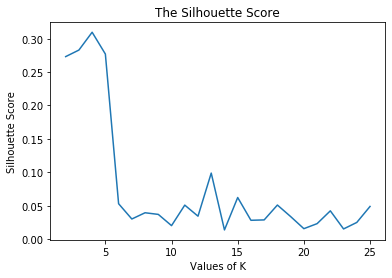

In [209]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(K, sil) 
plt.xlabel('Values of K') 
plt.ylabel('Silhouette Score') 
plt.title('The Silhouette Score') 
plt.show()

### Let's see the graph with K in range 2 - 5

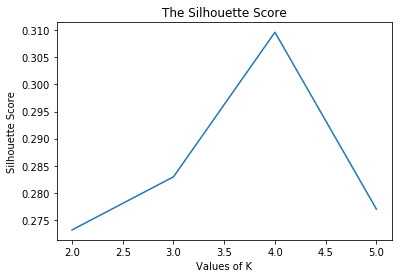

In [210]:
plt.plot(K[0:4], sil[0:4]) 
plt.xlabel('Values of K') 
plt.ylabel('Silhouette Score') 
plt.title('The Silhouette Score') 
plt.show()

### It turns out the best K will be 4 for now
Next, I will pass it to the Kmeans algorithm at the code below

In [327]:
# I will use 4 as the number of K
kclusters = 4

jakarta_grouped_Kmeans = jakarta_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state = 0).fit(jakarta_grouped_Kmeans)

# check the first 10 cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 3, 1, 2, 1, 1, 1])

### The next thing I will do is to construct a function that will return most common venues for each district
This dataframe then will be merged with the cluster labels that I have retrieved

In [264]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [326]:
#I will set the number to 7 since the difference in density is quite high
num_top_venues = 7

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = jakarta_grouped['District']

for ind in np.arange(jakarta_grouped.shape[0]):
    district_venues_sorted.iloc[ind, 1:] = return_most_common_venues(jakarta_grouped.iloc[ind, :], num_top_venues)

district_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,CAKUNG,Fast Food Restaurant,Video Store,Restaurant,Donut Shop,Noodle House,Chinese Restaurant,Women's Store
1,CEMPAKA PUTIH,Indonesian Restaurant,Café,Pizza Place,Noodle House,Fast Food Restaurant,Asian Restaurant,Indonesian Meatball Place
2,CENGKARENG,Internet Cafe,Vegetarian / Vegan Restaurant,Café,BBQ Joint,Women's Store,Fish & Chips Shop,French Restaurant
3,CILANDAK,Donut Shop,Pizza Place,Indonesian Restaurant,Farmers Market,Sandwich Place,Food Court,Bookstore
4,CILINCING,Seafood Restaurant,Women's Store,Farmers Market,French Restaurant,Food Truck,Food Stand,Food Court


### Next, I will merge the dataframe above with the cluster labels from each districts

In [328]:
district_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

jakarta_merged = df_merged

jakarta_merged = jakarta_merged.join(district_venues_sorted.set_index('District'), on='District')

jakarta_merged.head(20)

,District,Neighborhood,Total population,Latitude,Longitude,Approx distance,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,CAKUNG,"CAKUNG BARAT,CAKUNG TIMUR,JATINEGARA,PENGGILIN...",461622,-6.19623,106.93522,9.536157,1,Fast Food Restaurant,Video Store,Restaurant,Donut Shop,Noodle House,Chinese Restaurant,Women's Store
1,CEMPAKA PUTIH,"CEMPAKA PUTIH BARAT,CEMPAKA PUTIH TIMUR,RAWASARI",89799,-6.17600,106.87060,2.047533,1,Indonesian Restaurant,Café,Pizza Place,Noodle House,Fast Food Restaurant,Asian Restaurant,Indonesian Meatball Place
2,CENGKARENG,"CENGKARENG BARAT,CENGKARENG TIMUR,DURI KOSAMBI...",457629,-6.13060,106.74559,12.672799,1,Internet Cafe,Vegetarian / Vegan Restaurant,Café,BBQ Joint,Women's Store,Fish & Chips Shop,French Restaurant
3,CILANDAK,"CILANDAK BARAT,CIPETE SELATAN,GANDARIA SELATAN...",189780,-6.29051,106.79491,14.747089,1,Donut Shop,Pizza Place,Indonesian Restaurant,Farmers Market,Sandwich Place,Food Court,Bookstore
4,CILINCING,"CILINCING,KALIBARU,MARUNDA,ROROTAN,SEMPER BARA...",349075,-6.11358,106.94911,12.418460,3,Seafood Restaurant,Women's Store,Farmers Market,French Restaurant,Food Truck,Food Stand,Food Court
5,CIPAYUNG,"BAMBU APUS,CEGER,CILANGKAP,CIPAYUNG,LUBANG BUA...",237204,-6.32673,106.90298,18.183007,1,Food Truck,Women's Store,Fast Food Restaurant,Fried Chicken Joint,French Restaurant,Food Stand,Food Court
6,CIRACAS,"CIBUBUR,CIRACAS,KELAPA DUA WETAN,RAMBUTAN,SUSUKAN",263342,-6.32879,106.88475,17.896966,2,Pizza Place,Vegetarian / Vegan Restaurant,High School,Women's Store,Farmers Market,Food Truck,Food Stand
7,DUREN SAWIT,"DUREN SAWIT,KLENDER,MALAKA JAYA,MALAKA SARI,PO...",372835,-6.23501,106.92261,10.499846,1,Indonesian Meatball Place,Gym,Pet Store,Salon / Barbershop,Gym Pool,Convenience Store,Mediterranean Restaurant
8,GAMBIR,"CIDENG,DURI PULO,GAMBIR,KEBON KELAPA,PETOJO SE...",94310,-6.17299,106.81571,4.103136,1,Indonesian Restaurant,Camera Store,Coffee Shop,History Museum,Office,Seafood Restaurant,Music Venue
9,GROGOL PETAMBURAN,"GROGOL,JELAMBAR,JELAMBAR BARU,TANJUNG DUREN SE...",205166,-6.16777,106.78460,7.545080,1,Noodle House,Fast Food Restaurant,Coffee Shop,Asian Restaurant,Dessert Shop,Pizza Place,Chinese Restaurant


In [313]:
#let's check to see whether there are NaN values or not
#I can check it with the cluster labels, if the cluster labels returns NaN values that means the data within most common venues are NaN as well
#This is important since the map can't be generated if there are NaN values
jakarta_merged['Cluster Labels'].isna().sum()

0

### Finally, I make the map of the clusters and also use the labels from the previous map to give more comprehensive description in each nodes
**Again, if you can't see the map then it is probably you use the github notebook viewer,** to resolve this you can either open it in your own jupyter notebook or check the html that I will provide in my github called map_clusters.html

In [329]:
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[Jakarta_latitude, Jakarta_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, neighborhood, population, distance in zip(jakarta_merged['Latitude'], jakarta_merged['Longitude'], jakarta_merged['District'], jakarta_merged['Cluster Labels'], jakarta_merged['Neighborhood'], jakarta_merged['Total population'], jakarta_merged['Approx distance'] ):
    labels = 'Neighborhood = {}, population = {}, distance = {} km'.format(neighborhood, population, distance)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + '\n' + labels, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
      
map_clusters

In [424]:
#save it just in case
map_clusters.save('map_clusters.html')

# The next thing I will do is to check the place on each clusters and analyze the results

In [330]:
jakarta_merged.loc[jakarta_merged['Cluster Labels'] == 0, jakarta_merged.columns[[0] + list(range(7, jakarta_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
42,TANJUNG PRIOK,Asian Restaurant,Donut Shop,Women's Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Stand


In [332]:
jakarta_merged.loc[jakarta_merged['Cluster Labels'] == 1, jakarta_merged.columns[[0] + list(range(7, jakarta_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,CAKUNG,Fast Food Restaurant,Video Store,Restaurant,Donut Shop,Noodle House,Chinese Restaurant,Women's Store
1,CEMPAKA PUTIH,Indonesian Restaurant,Café,Pizza Place,Noodle House,Fast Food Restaurant,Asian Restaurant,Indonesian Meatball Place
2,CENGKARENG,Internet Cafe,Vegetarian / Vegan Restaurant,Café,BBQ Joint,Women's Store,Fish & Chips Shop,French Restaurant
3,CILANDAK,Donut Shop,Pizza Place,Indonesian Restaurant,Farmers Market,Sandwich Place,Food Court,Bookstore
5,CIPAYUNG,Food Truck,Women's Store,Fast Food Restaurant,Fried Chicken Joint,French Restaurant,Food Stand,Food Court
7,DUREN SAWIT,Indonesian Meatball Place,Gym,Pet Store,Salon / Barbershop,Gym Pool,Convenience Store,Mediterranean Restaurant
8,GAMBIR,Indonesian Restaurant,Camera Store,Coffee Shop,History Museum,Office,Seafood Restaurant,Music Venue
9,GROGOL PETAMBURAN,Noodle House,Fast Food Restaurant,Coffee Shop,Asian Restaurant,Dessert Shop,Pizza Place,Chinese Restaurant
10,JAGAKARSA,Gift Shop,Convenience Store,Coffee Shop,Women's Store,Fast Food Restaurant,French Restaurant,Food Truck
11,JATINEGARA,Coffee Shop,Spa,Airport,Women's Store,Fast Food Restaurant,French Restaurant,Food Truck


In [333]:
jakarta_merged.loc[jakarta_merged['Cluster Labels'] == 2, jakarta_merged.columns[[0] + list(range(7, jakarta_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
6,CIRACAS,Pizza Place,Vegetarian / Vegan Restaurant,High School,Women's Store,Farmers Market,Food Truck,Food Stand
26,MATRAMAN,Pizza Place,Women's Store,Farmers Market,French Restaurant,Food Truck,Food Stand,Food Court
31,PASAR MINGGU,Gas Station,Pizza Place,Farmers Market,French Restaurant,Food Truck,Food Stand,Food Court
32,PASAR REBO,Diner,Pizza Place,Women's Store,Fast Food Restaurant,French Restaurant,Food Truck,Food Stand


In [334]:
jakarta_merged.loc[jakarta_merged['Cluster Labels'] == 3, jakarta_merged.columns[[0] + list(range(7, jakarta_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
4,CILINCING,Seafood Restaurant,Women's Store,Farmers Market,French Restaurant,Food Truck,Food Stand,Food Court


# Analysis and Discussion
Thanks to the silhouette method the number of clusters are 4 with no empty nodes (label 0,1,2,3).  
You readers may ask why there are so many districts labeled in cluster label 1.
The answer to that question is within the frequency, you will understand if you check the code that I offer later on.  

From the results above, I will pick cluster label 0, 2 and 3 for further analysis, since it seems those clusters will have less competition if our client want to open a specialty coffee shop.

### This code below will return the top venues from each districts in cluster label 0, 2 and 3
From this code you will notice that cluster 2 are leaned to be clustered to one of its most recurring venue which is pizza place, while there are some labels in cluster 1 that also has pizza place, the frequency might differ in the second most recurring venue (or perharps the first).  

On the other hand, the CILINCING and TANJUNG PRIOK district were also in different cluster, if you notice their first and second venue frequency were quite unique from other clusters. That's why, in my opinion, they were in their own different clusters.

If I want to different description for each label, it would be:
1. Label 0 : Districts with moderate level competition with Asian restaurant and Donut shop as its main competitor
2. Label 1 : Districts with moderate to high level competition with various unique venues as its main competitor
3. Label 2 : Districts with low to moderate level competition with pizza place as its main competitor
4. Label 3 : Districts with low level competition with seafood restaurant as its main competitor.

In [354]:
freq_check = jakarta_grouped[jakarta_grouped["District"].isin(["MATRAMAN", "CIRACAS", "PASAR MINGGU", "PASAR REBO", "CILINCING", "TANJUNG PRIOK"])]

In [367]:
num_top_venues = 7

for hood in freq_check['District']:
    print("----"+hood+"----")
    temp = freq_check[freq_check['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----CILINCING----
                   venue  freq
0     Seafood Restaurant   1.0
1      Accessories Store   0.0
2              Pet Store   0.0
3           Noodle House   0.0
4                 Office   0.0
5  Padangnese Restaurant   0.0
6                 Palace   0.0


----CIRACAS----
                           venue  freq
0                    Pizza Place  0.50
1                    High School  0.25
2  Vegetarian / Vegan Restaurant  0.25
3                           Park  0.00
4                      Nightclub  0.00
5                   Noodle House  0.00
6                         Office  0.00


----MATRAMAN----
                   venue  freq
0            Pizza Place   1.0
1      Accessories Store   0.0
2                   Park   0.0
3              Nightclub   0.0
4           Noodle House   0.0
5                 Office   0.0
6  Padangnese Restaurant   0.0


----PASAR MINGGU----
                   venue  freq
0            Gas Station   0.5
1            Pizza Place   0.5
2                   P

## Now, I will pick the place that has less competition
Based from the client's first concern, I will pick the place with less competition. In this case, I will pick the place with less frequency of cafes, restaurants and other type of veues.  

From the results above, I can see from the district MATRAMAN (cluster 2) and CILINCING (cluster 3) has less competition. The other district from cluster 2 will be dropped, since from the map I can see that district MATRAMAN was close to the supplier place compared to other districts in the same cluster.

After that I will run the code below to see the distance between the district MATRAMAN, CILINCING and supplier's location. This is done in order to fulfill the client's second concern which is the distance from the supplier's location.

In [363]:
pick_it = jakarta_merged[jakarta_merged["District"].isin(["MATRAMAN", "CILINCING"])]
pick_it_sorted = pick_it.drop(pick_it.columns[7:], axis=1)
pick_it_sorted.reset_index(drop=True)

,District,Neighborhood,Total population,Latitude,Longitude,Approx distance,Cluster Labels
0,CILINCING,"CILINCING,KALIBARU,MARUNDA,ROROTAN,SEMPER BARA...",349075,-6.11358,106.94911,12.418460,3
1,MATRAMAN,"KAYU MANIS,KEBON MANGGIS,PALMERIAM,PISANGAN BA...",166222,-6.19983,106.86268,3.386755,2


### From the results above, we have a clear winner which is MATRAMAN district
After this, I will move on to the client's third concern which is **the place with adequate population.**

By using the code from the first section of pre-processing of the dataset, I will retrieve the total number of population within each neighboods of MATRAMAN district.

In [385]:
matraman = df.set_index('District')
matraman_population = matraman.loc['MATRAMAN']
matraman_population_sorted = matraman_population.groupby(['Neighborhood'])['Total population'].sum().reset_index()

In [386]:
matraman_population_sorted

,Neighborhood,Total population
0,KAYU MANIS,25205
1,KEBON MANGGIS,18624
2,PALMERIAM,22415
3,PISANGAN BARU,33192
4,UTAN KAYU SELATAN,37406
5,UTAN KAYU UTARA,29380


### Finally I will plot a graph so my client can see the result with more aesthetic touch

<Figure size 432x288 with 0 Axes>

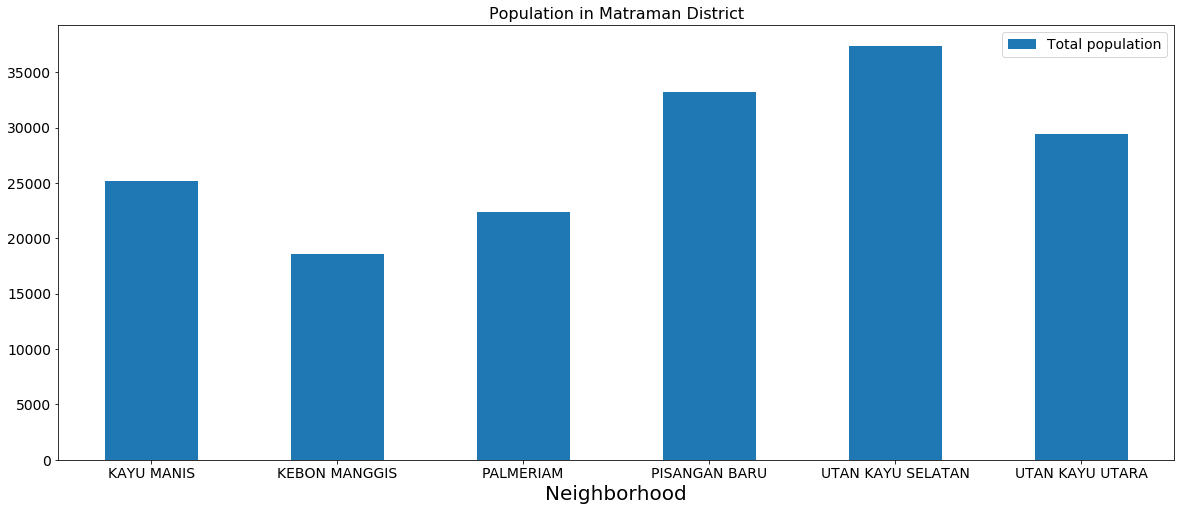

In [423]:
ax = matraman_population_sorted.plot(kind='bar', x='Neighborhood', figsize=(20,8), rot = 0, fontsize = 14)
ax.set_xlabel('Neighborhood', fontsize=20)
ax.set_title("Population in Matraman District", fontsize = 16)
ax.legend(fontsize =14)

# Conclusion
From the result above, I will recommend the client to open a specialty coffee shop in UTAN KAYU SELATAN neighborhood which resides in MATRAMAN district. The reasons are:
1. MATRAMAN district has less competition compared with other district
2. MATRAMAN district is closer to the supplier's place compared with other district that also has less competition
2. UTAN KAYU SELATAN neighborhood in MATRAMAN district is the chosen place to open the specialty coffee shop because the population within that area is the highest compared with other neighborhoods in the MATRAMAN district

# Afterword
These are my personal opinion about this project:  
1. The analysis above will have different results if you use Google Maps API instead. Personally, I think Gmaps has more comprehensive data set of Indonesia compared with foursquare, but the price is too expensive if you just want to do a one time project like this.
2. If, somehow, you use google maps API and see the results have few differences in densities and you want to have more accurate results (to see whether there is cluster within clusters), DBScan might be preferred to solve it.
3. Elbow method can also be used to retrieve optimum K in Kmeans, this may produce slightly different result but it is worth to try.
4. You can also set the number iteration in the KMeans function, the default is 10. If you perhaps want to play with the code, you can tweak this variable alongside the random state.